# CG法

## JuliaによるCG法の実装 (from scratch)
JuliaでCG法を0から実装し，次の連立１次方程式（[齊藤共立，例3.21]と同じ問題）を
テスト問題として近似解を計算してみよう．

$$
 \begin{pmatrix}
	3 & -1 & 2 \\ -1 & 4 & 1 \\ 2 & 1 & 3
 \end{pmatrix}	
 \begin{pmatrix} x_1 \\ x_2 \\ x_3 \end{pmatrix}
 =
 \begin{pmatrix} 4 \\ 4 \\ 6 \end{pmatrix}
$$

厳密解は$x_1 = x_2 = x_3 = 1$である．$A$は正定値対称行列である．


In [1]:
using LinearAlgebra

A = Float64[3 -1 2; -1 4 1; 2 1 3]
b = Float64[4, 4, 6]
x = [0, 0, 0]   # 初期値
r = r0 = b - A*x  # 初期残差
p = r
tol = 1e-6   # 停止条件のtolerance
maxiter = 100  # 最大反復回数（適宜，多めに回数に設定する）

# 固有値の確認
@show eigvals(A)

# CG法による反復計算
for i in 1:maxiter
    alpha = r'*p/(p'*A*p)
    xx = x + alpha*p
    # 停止条件
    # (norm(xx - x) < tol) && break
    x = xx
    r = r - alpha*A*p
    @show i, Float32.(x), norm(r)/norm(r0)    # 途中経過の表示
    (norm(r) < tol*norm(r0)) && break
    beta = r'*A*p/(p'*A*p)
    p = r - beta*p
end
@show x   # 数値解の表示

eigvals(A) = [0.4384471871911705, 4.561552812808831, 5.0]
(i, Float32.(x), norm(r) / norm(r0)) = (1, Float32[0.8192771, 0.8192771, 1.2289157], 0.04344037681281916)
(i, Float32.(x), norm(r) / norm(r0)) = (2, Float32[0.7968128, 0.90039843, 1.1952192], 0.017419813390342823)
(i, Float32.(x), norm(r) / norm(r0)) = (3, Float32[1.0, 1.0, 1.0], 4.687735131751619e-16)
x = [1.000000000000001, 1.0000000000000009, 0.9999999999999999]


3-element Vector{Float64}:
 1.000000000000001
 1.0000000000000009
 0.9999999999999999

この場合は3回の反復で厳密解が得られている．

最大反復回数と停止条件のtoleranceは問題に応じて適切な数値に適宜変更されたい．
なお，途中経過を表示するコードのところで`Float.32(x)`と単精度型に変換しているのは
表示桁数を減らすためである．

## IterativeSolvers.jl 
IterativeSolversパッケージには CG法などの反復法が実装されている．詳細は公式ドキュメントの[Conjugate Gradients (CG)](https://iterativesolvers.julialinearalgebra.org/stable/)を参照．

`Ax = b` をCG法で解くには，`cg(A,b)` を実行すればよい．


In [2]:
# パッケージの追加
#]add IterativeSolvers 

In [3]:
using IterativeSolvers
A = Float64[3 -1 2; -1 4 1; 2 1 3]
b = Float64[4, 4, 6]
x = cg(A,b)  # CG法

3-element Vector{Float64}:
 1.0000000000000007
 1.0000000000000004
 0.9999999999999991

収束履歴(convergence history)を含むログを取得したい場合は，キーワード引数で `log=true` を与える．
第2戻り値にログが格納される．

In [4]:
x,ch = cg(A,b,log=true)

([1.0000000000000007, 1.0000000000000004, 0.9999999999999991], Converged after 3 iterations.)

3回の反復後，相対残差 $\dfrac{\|\vec{r}_k\|}{\|\vec{r}_0\|}$ が tolerance を下回り停止したことがわかる．

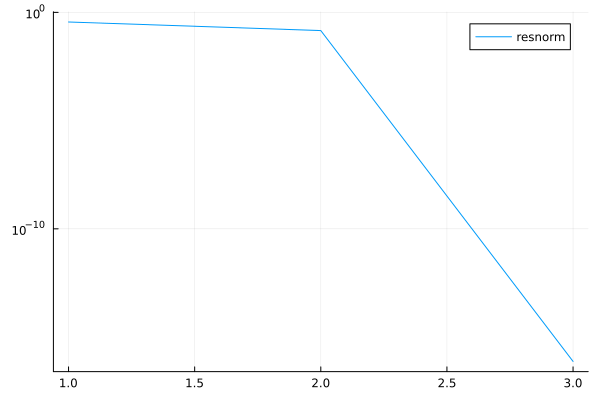

In [5]:
using Plots
plot(ch, yaxis=:log)  # y軸はlog-scale

## ノート
公式ドキュメントを見てもログ変数のどこに収束履歴が格納されているかわからないので，変数の中身をダンプして確認する．

In [6]:
dump(ch)

ConvergenceHistory{true, Nothing}
  mvps: Int64 3
  mtvps: Int64 0
  iters: Int64 3
  restart: Nothing nothing
  isconverged: Bool true
  data: Dict{Symbol, Any}
    slots: Array{UInt8}((16,)) UInt8[0x00, 0x00, 0x00, 0x00, 0x00, 0xfc, 0x00, 0x00, 0xed, 0x00, 0x00, 0x00, 0x00, 0x00, 0xdf, 0x00]
    keys: Array{Symbol}((16,))
      1: #undef
      2: #undef
      3: #undef
      4: #undef
      5: #undef
      ...
      12: #undef
      13: #undef
      14: #undef
      15: Symbol resnorm
      16: #undef
    vals: Array{Any}((16,))
      1: #undef
      2: #undef
      3: #undef
      4: #undef
      5: #undef
      ...
      12: #undef
      13: #undef
      14: #undef
      15: Array{Float64}((3,)) [0.35821852403177135, 0.1436474611738647, 7.465789177005377e-17]
      16: #undef
    ndel: Int64 0
    count: Int64 3
    age: UInt64 0x0000000000000003
    idxfloor: Int64 6
    maxprobe: Int64 0


--- 

`iters`は収束するまでの要した反復回数であることは間違いないだろう．
`data` の出力が長いので，収束履歴が格納されている可能性が高い．

In [7]:
ch.data

Dict{Symbol, Any} with 3 entries:
  :reltol  => 1.49012e-8
  :abstol  => 0.0
  :resnorm => [0.358219, 0.143647, 7.46579e-17]

In [8]:
ch.data[:resnorm]

3-element Vector{Float64}:
 0.35821852403177135
 0.1436474611738647
 7.465789177005377e-17

これが残差の履歴と思われる．